# Fully Dynamic k-center Clustering

## Parsing

This section has to be runned only once; its role is to parse the data and create a .hdf5 dataset with three fields: one for the timestamp, one for the latitude, one for the longitude. We will use this file in the following sections.

In [1]:
import h5py
def parse_input(path):
    """
    A function that reads the raw data contained in the txt file, parse them
    and puts them in three different fields of a h5 file : a field for
    timestamps, a field for latitudes, and a field for longitudes.
    """
    dataset = h5py.File("dataset.hdf5", "w")
    timestamps = dataset.create_dataset("timestamps", (1000000,), dtype='i')
    latitudes = dataset.create_dataset("latitudes", (1000000,), dtype='f')
    longitudes = dataset.create_dataset("longitudes", (1000000,), dtype='f')
    f = open(path,'r')
    for i, line in enumerate(f):
        line = line.split()
        timestamps[i] = int(line[0])
        latitudes[i] = float(line[1])
        longitudes[i] = float(line[2])
    dataset.close()

In [2]:
"""we parse the txt file assuming it is located in the same directory as
the current Notebook"""

parse_input('dataset/twitter_1000000.txt')

## Data visualization

Just to check that our geographical data look relevant, *i.e* that it "coincides" with a world map (at least on the part of the world that are conneted to Twitter!)

In [4]:
# we open the h5 file that contains the data
import h5py
f = h5py.File('dataset.hdf5', 'r')

In [5]:
# we put the data into lists
timestamps = f['timestamps'] # array of numpy ints
latitudes = f['latitudes'] # list of numpy floats
longitudes = f['longitudes'] # list of numpy floats

# we test that the file is not corrupted
print("Timestamps    Latitudes    Longitudes\n")
for i in range(0, 10):
    print(str(timestamps[i]) + "    " + str(latitudes[i]) + "    " + str(longitudes[i]))

Timestamps    Latitudes    Longitudes

1504866207    0.375267    52.2639
1504866208    121.035    14.6517
1504866208    -61.2052    -27.2133
1504866209    101.691    3.05276
1504866209    12.3267    45.4386
1504866209    135.504    34.6802
1504866209    139.753    35.6544
1504866209    139.776    35.7133
1504866209    4.08333    48.3
1504866210    103.855    1.30046


In [6]:
dataset = list(zip(latitudes, longitudes)) # list of tuples (lat, lon)

# we check if the zip did it right
print("Latitudes    Longitudes\n")
for i in range(0, 10):
    print(str(dataset[i][0]) + "    " + str(dataset[i][1]))

Latitudes    Longitudes

0.375267    52.2639
121.035    14.6517
-61.2052    -27.2133
101.691    3.05276
12.3267    45.4386
135.504    34.6802
139.753    35.6544
139.776    35.7133
4.08333    48.3
103.855    1.30046


In [7]:
# we select a random sample of the points
import numpy as np
import matplotlib.pyplot as plt
import random
sample_dataset = random.sample(dataset, 4000)
sample_latitudes = [sample[0] for sample in sample_dataset]
sample_longitudes = [sample[1] for sample in sample_dataset]

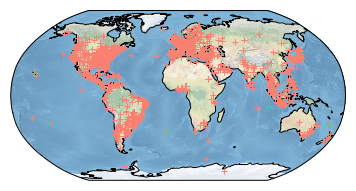

In [8]:
"""we plot the sample points on a map in order to check if the positions of
the points seem relevant with the positions of the continents"""

import cartopy.crs as ccrs
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()
ax.stock_img()
ax.coastlines()
plt.plot(sample_latitudes, sample_longitudes, '+', transform=ccrs.PlateCarree(), color='salmon')
plt.show()

## Computation of the Betas

First we create a dictionnary that maps an *id* (i.e. an int) two each tweet,
defined by its coordinates (i.e. a tuple of floats). From now on, we will 
manipulate point through their *id*, because it seems more convenient and efficient.

In [9]:
import numpy as np

id_to_coords = {i : point for i, point in enumerate(dataset)}

### Definition of the metric

Here we define a metric that is consistent with the data we deal with : the **Haversine distance**, which is basically the number of kilometers between two points located with their GPS coordinates.
We will use this metric to compute all the distances that are used during the project (including min and max distances between each pair of points, which have a direct incidence on the *betas*).

In [10]:
import math

def Haversine(point, neighbor):
    """
    The function takes two tuples (two points) and computes their Haversin distance
    """
    lat1 = point[0]
    lat2 = neighbor[0]
    lon1 = point[1]
    lon2 = neighbor[1]
    R=6371000                             
    phi_1=math.radians(lat1)
    phi_2=math.radians(lat2)

    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi/2.0)**2 + math.cos(phi_1) * math.cos(phi_2) * math.sin(delta_lambda/2.0)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
        
    return R*c/1000

In [11]:
"""we check whether the Haversine distance between two points (in kilometers)
seems to be ok"""

print("Distance between point 1 and point 2 : " + str(Haversine(dataset[0], dataset[1])) + " km")
print("Distance between point 1 and point 3 : " + str(Haversine(dataset[0], dataset[2])) + " km")
print("Distance between point 2 and point 3 : " + str(Haversine(dataset[1], dataset[2])) + " km")

Distance between point 1 and point 2 : 12648.7174267 km
Distance between point 1 and point 3 : 9483.09288633 km
Distance between point 2 and point 3 : 17720.5130311 km


### Min and max distances

Here we go through a kind of technical part. In a first trial, we used the *pdist* function from the spatial Scipy package which computes the pairwise distances between all points within a dataset. But this function ran out of memory because there was to many points (tweets) to handle in our case.

Then we thought we should not compute **all** the distances, because after all we were just interested in very special distances of our dataset (*i.e.* the minimum and the maximum paitwise distances!). We thus chose to use more refined methods with a lower complexity.

So we define here two methods that compute respectively the minimum pairwise distance and the pairwise maximum between all points in our dataset. The code snippets that follow are strongly inspired from :
- https://stackoverflow.com/questions/5119644/identifying-points-with-the-smallest-euclidean-distance (for the Delaunay triangulation and the min distance)
- https://www.ics.uci.edu/~eppstein/161/python/diameter.py (for the Rotating Calipers and the max distance)

In [12]:
from scipy import spatial

def min_distance(dataset):
    """
    This function computes the distance between the two closest points of the dataset.
    It is based on the Delaunay triangulation (by definition the closest pair of
    points in a set define an edge in the Delaunay triangulation of this set). We 
    adapted a bit the original version (that relies on the Euclidean distance), to
    consider instead the Haversine distance
    """
    # set up the triangulation
    mesh = spatial.Delaunay(dataset)
    edges = np.vstack((mesh.vertices[:,:2], mesh.vertices[:,-2:]))
    points1 = mesh.points[edges[:,0]]
    points2 = mesh.points[edges[:,1]]
    
    # here we adapted the code to use the Haversine distance instead of the Euclidean
    dists = ([Haversine(p1, p2) for p1, p2 in zip(points1, points2)])
    idx = np.argmin(dists)
    i, j = edges[idx]
    return Haversine(dataset[i], dataset[j])

In [13]:
from __future__ import generators

def orientation(p,q,r):
    """
    Return positive number if p-q-r are clockwise, neg if ccw, zero if colinear.
    """
    return (q[1]-p[1])*(r[0]-p[0]) - (q[0]-p[0])*(r[1]-p[1])

def hulls(dataset):
    """
    Graham scan to find upper and lower convex hulls of a set of 2d points.
    """
    U = []
    L = []
    dataset.sort()
    for p in dataset:
        while len(U) > 1 and orientation(U[-2],U[-1],p) <= 0: U.pop()
        while len(L) > 1 and orientation(L[-2],L[-1],p) >= 0: L.pop()
        U.append(p)
        L.append(p)
    return U,L

def rotating_calipers(dataset):
    """
    Given a list of 2d points, finds all ways of sandwiching the points between
    two parallel lines that touch one point each, and yields the sequence of pairs of
    points touched by each pair of lines.
    """
    U,L = hulls(dataset)
    i = 0
    j = len(L) - 1
    while i < len(U) - 1 or j > 0:
        yield U[i],L[j]
        
        # if all the way through one of top or bottom, advance the other
        if i == len(U) - 1: j -= 1
        elif j == 0: i += 1
        
        # still points left on both lists, compare slopes of next hull edges
        elif (U[i+1][1]-U[i][1])*(L[j][0]-L[j-1][0]) > \
                (L[j][1]-L[j-1][1])*(U[i+1][0]-U[i][0]):
            i += 1
        else: j -= 1

def max_distance(dataset):
    """
    Given a list of 2d points, returns the pair that is farthest apart.
    The key is to use the method of rotating calipers, an algorithm design
    technique that can be used to solve optimization problems including
    finding the width or diameter of a set of points (that is what we want).
    """
    best_dist = 0
    for p1, p2 in rotating_calipers(dataset):
        dist = Haversine(p1, p2)
        if dist > best_dist:
            best_dist = dist
    return best_dist

In [14]:
max_dist = max_distance(dataset)

In [15]:
min_dist = min_distance(np.asarray(dataset))

In [16]:
print("Max distance : " + str(max_dist))
print("Minimum distance : " + str(min_dist))

Max distance : 18680.1424983
Minimum distance : 8.50586308516e-07


### Computation of the betas w.r.t epsilon

In [17]:
def compute_betas_for_fixed_eps(max_dist, min_dist, eps):
    betas = []
    i_min = int(math.ceil(math.log(min_dist)/math.log(1+eps)))
    i_max = int(math.floor(math.log(max_dist)/math.log(1+eps)))
    for i in range(i_min, i_max+1):
        betas.append((1+eps)**i)
    return betas

def compute_betas(max_dist, min_dist, epsilons):
    eps_to_betas = {}
    for eps in epsilons:
        betas = compute_betas_for_fixed_eps(max_dist, min_dist, eps)
        eps_to_betas[eps] = betas
        print('Number of betas for epsilon = ' + str(eps) + ' : ' + str(len(betas)))
    return eps_to_betas

In [18]:
epsilons = list(np.arange(0.1, 1.1, 0.1))
eps_to_betas = compute_betas(max_dist, min_dist, epsilons)

Number of betas for epsilon = 0.1 : 250
Number of betas for epsilon = 0.2 : 130
Number of betas for epsilon = 0.3 : 91
Number of betas for epsilon = 0.4 : 71
Number of betas for epsilon = 0.5 : 59
Number of betas for epsilon = 0.6 : 50
Number of betas for epsilon = 0.7 : 45
Number of betas for epsilon = 0.8 : 40
Number of betas for epsilon = 0.9 : 37
Number of betas for epsilon = 1.0 : 35


# Static clustering

## Building a clustering for a fixed beta

In [19]:
def build_cluster(center_id, beta, dataset_ids, clusters, verbose):
    """
    This function takes the id of a cluster center, a certain beta, the list of
    point ids that are active within the dataset and still need to be clustered,
    and the dictionary of the clusters that have been built so far.
    
    It scans all the points that remain to be clustered and adds a point to the
    cluster if it is at a distance at most 2*beta from the center. 'Adding the
    point' to the cluster means mapping the point id to the center id within the
    clusters dictionnary (clusters), and removing the point from the list of
    points that have to be clustered (dataset_ids).
    """
    
    center = id_to_coords[center_id]    
    i = 0
    k = 0
    while True:
        if i >= len(dataset_ids):
            # we have scanned all the points that remained to be clustered
            break      
        k += 1
        point_id = dataset_ids[i]
        distance = Haversine(center, id_to_coords[point_id])
        if distance <= 2*beta:
            clusters[point_id] = (center_id)
            dataset_ids.remove(point_id)
        else:
            i += 1
            
    if verbose:
        print(str(k) + ' points have been scanned')
        print(str(len(dataset_ids)) +' points remain to be affected\n')
    return dataset_ids, clusters

In [20]:
from copy import deepcopy

def build_beta_clustering(k, beta, dataset_ids, verbose):
    """
    This function creates the whole clustering for a fixed valued of beta,
    by iterating the function build_clusters until k clusters have been found
    or until there are no more points to cluster. In the first case, the
    points that have not been clustered are labeled as outliers. The label
    for outliers is set at -1, which cannot be the id of any point (the ids
    are naturals). During the process, we keep track of the order of creation
    of the cluster (i.e. we store the centers ids in order). This will be useful
    in the dynamic version during the reclustering part.
    """
    clusters = {point_id : -1 for point_id in dataset_ids}
    # at the beginning, all points are labeled as outliers
    
    order = []
    d = deepcopy(dataset_ids)
    # we create a deep copy of the dataset such that the original one is preserved
    
    for i in range(0, k):
        if not d:
            break
        center_id = random.choice(d)
        # we pick u.a.r a not-yet-clustered point to build a new cluster around it
        
        order.append(center_id)
        # we keep track of the order of creation of the clusters through the center id
        
        d.remove(center_id)
        # the center no longer needs to be clustered !
        clusters[center_id] = center_id
        # the center belongs to its own cluster !

        if verbose:
            print('Building cluster ' + str(i+1) + ' whose center is ' + str(center_id))
        d, clusters = build_cluster(center_id, beta, d, clusters, verbose)
    return clusters, order

## Building clusterings for a list of betas

In [21]:
def build_betas_clustering(k, betas, dataset_ids, verbose):
    """
    This function takes a list of betas and computes a clustering for each
    beta of the list. It also computes, for each beta, the order of creation
    of the clusters (useful for the reclustering part).
    """
    clustering, ordering = {}, {}
    # these are dictionaries that map a value of beta to a clustering and an
    # ordering (which means an ordered list of the centers' ids).
    
    for beta in betas:
        if verbose:
            print('Computing for beta = ' + str(beta) + '\n')
        clusters, order  = build_beta_clustering(k, beta, dataset_ids, verbose)
        ordering[beta] = order
        clustering[beta] = clusters
    return clustering, ordering

## Building clusterings for a list of epsilons (list of lists of betas)

In [39]:
def build_epsilons_clustering(k, eps_to_betas, dataset_ids, verbose):
    """
    This function computes a series of clustering for each epsilon
    (i.e. a clustering for beta associated to this epsilon). It also keeps 
    track of the clustering order, for each epsilon, for each beta.
    """
    times = []
    whole_clustering, whole_ordering = {}, {}
    
    for eps, betas in eps_to_betas.items():
        start = time.time()
        clustering, ordering = build_betas_clustering(k, betas, dataset_ids, verbose)
        whole_clustering[eps] = clustering
        whole_ordering[eps] = ordering
        end = time.time()
        times.append(end-start)
    return whole_clustering, whole_ordering, times

## Tests and visualizations

In [40]:
beta_test = 1500
eps_test = 0.1
clustering, ordering, times = build_epsilons_clustering(8, {eps_test : [beta_test]}, random.sample(list(range(0, 1000000)), 20000), True)
print(times)

Computing for beta = 1500

Building cluster 1 whose center is 922402
19999 points have been scanned
13897 points remain to be affected

Building cluster 2 whose center is 427615
13896 points have been scanned
11134 points remain to be affected

Building cluster 3 whose center is 936948
11133 points have been scanned
9500 points remain to be affected

Building cluster 4 whose center is 626361
9499 points have been scanned
6984 points remain to be affected

Building cluster 5 whose center is 497609
6983 points have been scanned
4488 points remain to be affected

Building cluster 6 whose center is 238424
4487 points have been scanned
2233 points remain to be affected

Building cluster 7 whose center is 885299
2232 points have been scanned
792 points remain to be affected

Building cluster 8 whose center is 128210
791 points have been scanned
785 points remain to be affected

[3.1722300052642822]


In [41]:
from collections import defaultdict

def plot_cluster_sizes(clusters):
    counts = defaultdict(int)
    count_outliers = 0
    for point_id, center_id in clusters.items():
        if center_id == -1:
            count_outliers += 1
        else:
            counts[center_id] += 1
    barlist = plt.bar(np.arange(len(counts.keys())+1), counts.values() + [count_outliers])
    barlist[-1].set_color('r')
    plt.ylabel('Number of points')
    plt.xlabel('Clusters')
    plt.title('Size repartition of the clusters (red bar = outliers)')
    plt.show()

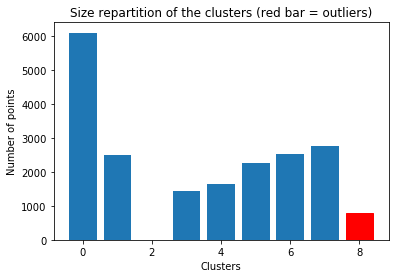

In [42]:
plot_cluster_sizes(clustering[eps_test][beta_test])

In [43]:
def plot_clusters_on_map(clusters, order):
    centers_ids = order
    col = ['salmon', 'plum', 'lime', 'lavender', 'goldenrod',
           'aquamarine', 'orangered', 'darkgreen', 'sienna',
           'navy', 'crimson', 'yellow', 'cyan', 'darkolivegreen',
          'darkorange', 'khaki', 'darkorchid', 'darkslategrey', 
          'palegreen', 'steelblue'] 
    fig = plt.figure(figsize=(8, 10), dpi=100)
    ax = plt.axes(projection=ccrs.Robinson())
    ax.set_global()
    ax.stock_img()
    ax.coastlines()
    for center_id in centers_ids:
        affected_points = [point_id for point_id, c in clusters.items() if c == center_id]
        affected_points = random.sample(affected_points, min(200, len(affected_points)))
        latitudes = [id_to_coords[i][0] for i in affected_points]
        longitudes = [id_to_coords[i][1] for i in affected_points]
        c = col[centers_ids.index(center_id)]
        plt.plot(latitudes, longitudes, '+', transform=ccrs.PlateCarree(), color=c)
        center_latitude = id_to_coords[center_id][0]
        center_longitude = id_to_coords[center_id][1]
        plt.plot(center_latitude, center_longitude, 'o', transform=ccrs.PlateCarree(), color=c, markeredgewidth=1., markeredgecolor='black')
    plt.title('Cluster samples (round=centers; cross=random points)')
    plt.show()

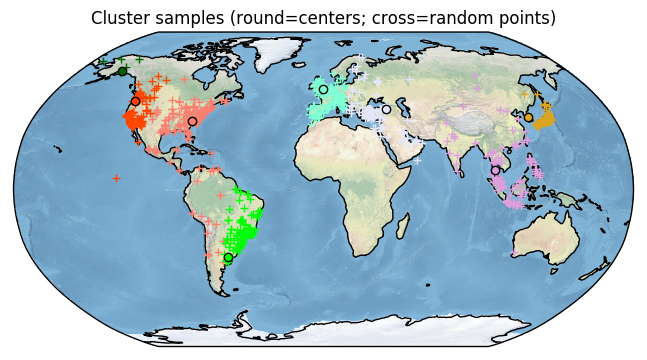

In [44]:
plot_clusters_on_map(clustering[eps_test][beta_test], ordering[eps_test][beta_test])

# Dynamic clustering

## Insertion

In [45]:
def insertion(k, point_id, clustering, ordering, verbose):
    """
    This function takes a point and adds it to the differents clusterings
    maintained in parallel (that depend on epsilon and the related betas).
    The point is added to an existing cluster if it fits in a 2*beta
    neighborhood around a center (we consider the centers from the oldest
    to the newest). Otherwise, it becomes the center of its own cluster (if
    we have not reached the maximal number of clusters) or an outlier.
    """
    times = []
    point = id_to_coords[point_id]
    if verbose:
        print('New point to be added : ' + str(point_id))
    for epsilon, betas_clustering in clustering.items():
        start = time.time()
        for beta, beta_clustering in betas_clustering.items():
            if verbose:
                print('Inserting in the clustering of beta = ' + str(beta))
            if point_id in beta_clustering.keys():
                if verbose:
                    print('This point already exists : no changes')
                break
            centers_ids = ordering[epsilon][beta]
            found = 0
            for center_id in centers_ids:
                center = id_to_coords[center_id]
                if Haversine(center, point) <= 2*beta:
                    if verbose:
                        print('This point belongs to the cluster of point ' + str(center_id) + '\n')
                    beta_clustering[point_id] = center_id
                    found = 1
                    break
            if found == 0:
                if len(centers_ids) < k:
                    beta_clustering[point_id] = point_id
                    centers_ids.append(point_id)
                    if verbose:
                        print('This point will form a new cluster\n')
                else:
                    if verbose:
                        print('This point is not yet affected to any cluster\n')
                    beta_clustering[point_id] = -1
        end = time.time()
        times.append(end-start)
    return clustering, ordering, times

## Test of the insertion algorithm

In [47]:
# to check if new clusters are created buy inserted points, set k to a
# huge value (200...), and beta to a small value (500...)

# to check if inserted points are cleverly affected to existing clusters,
# set k to a reasonable value (10...), and beta to a high value (1500...)

# to check if inserted points are considered as outliers when they are not
# close to any clusters and when the number of clusters is already maximal, 
# set k to a small value (5...) and beta to a small value (500...)

beta_test = 500
eps_test = 0.5
k = 20
dataset_ids = list(range(0, 100)) 
clustering, ordering, _ = build_epsilons_clustering(k, {eps_test : [beta_test]}, dataset_ids, True)
new_points = random.sample(list(range(500, 1000000)), 20)
for new_point in new_points:
    clustering, ordering, _ = insertion(k, new_point, clustering, ordering, True)
    print('Length of the new dataset : ' + str(len(clustering[eps_test][beta_test].values())))
    n_clusters = len(ordering[eps_test][beta_test])
    print('Number of clusters : ' + str(n_clusters))
    center_id = clustering[eps_test][beta_test][new_point]
    if center_id != -1:
        new_point = id_to_coords[new_point]
        center = id_to_coords[center_id]
        print('Distance between the new point and its center : ' + str(Haversine(center, new_point)) + '\n')

Computing for beta = 500

Building cluster 1 whose center is 71
99 points have been scanned
85 points remain to be affected

Building cluster 2 whose center is 62
84 points have been scanned
83 points remain to be affected

Building cluster 3 whose center is 33
82 points have been scanned
77 points remain to be affected

Building cluster 4 whose center is 80
76 points have been scanned
73 points remain to be affected

Building cluster 5 whose center is 88
72 points have been scanned
66 points remain to be affected

Building cluster 6 whose center is 28
65 points have been scanned
65 points remain to be affected

Building cluster 7 whose center is 61
64 points have been scanned
56 points remain to be affected

Building cluster 8 whose center is 5
55 points have been scanned
32 points remain to be affected

Building cluster 9 whose center is 87
31 points have been scanned
29 points remain to be affected

Building cluster 10 whose center is 51
28 points have been scanned
25 points remain 

## Deletion

In [48]:
def deletion(point_id, clustering, ordering, verbose):
    """
    This function handles point deletion while maintaining the parzallel
    clustering (one clustering per value of beta, and several beta per value
    of epsilon...). If the point to be deleted is not a cluster center, we
    just remove it and leave the global clustering unchanged. If it is a
    center, we recluster all the points that  are affected to clusters
    "younger" than the cluster that has been destroyed.
    """
    times = []
    for epsilon, betas_clustering in clustering.items():
        start = time.time()
        for beta, beta_clustering in betas_clustering.items():
            if verbose:
                print('Deleting in the clustering of beta = ' + str(beta))
            if point_id not in beta_clustering.keys():
                if verbose:
                    print('This point does not exist : no changes')
                break
            beta_ordering = ordering[epsilon][beta]
            if point_id not in beta_ordering:
                if verbose:
                    print('This point was not a center, the deletion does not affect the whole clustering')
                del beta_clustering[point_id]
            else:
                if verbose:
                    print('This point is a center : reclustering all the clusters created after it')
                del beta_clustering[point_id]
                i = beta_ordering.index(point_id)
                # we capture the age of the cluster that has been destroy, to reconstruct
                # all the clusters that are younger than it
                if verbose:
                    total_n_clusters = len(beta_ordering)
                    print('This point was the center of the cluster n° : ' + str(i))
                    print('We will have to recluster ' + str(total_n_clusters-i) + ' clusters')
                
                centers_to_recluster = beta_ordering[i:]
                beta_ordering = beta_ordering[:i]
                n_to_recluster = len(centers_to_recluster)
                centers_to_recluster.append(-1)
                # we will try to recluster all the outliers aas well !
                
                points_to_recluster = [p for p, c in beta_clustering.items() if c in centers_to_recluster]
                # we collect all the points that were affected to the "younger" clusters
                
                sub_clusters, sub_order = build_beta_clustering(n_to_recluster, beta, points_to_recluster, verbose)
                # we get a reclustering of the "younger" clusters only
                
                beta_clustering, beta_ordering = merge(beta_clustering, beta_ordering, sub_clusters, sub_order)
                # we merge the "older" clustering with the newer clustering
        end = time.time()
        times.append(end-start)
    return clustering, ordering, times

def merge(clusters, order, sub_clusters, sub_order):
    order = order + sub_order
    for point_id, center_id in sub_clusters.items():
        clusters[point_id] = center_id
    return clusters, order   

## Test of the deletion algorithm

In [49]:
# we test with a little beta and a big k to obtain a lot of little clusters, so
# that we have more chances to see a reclustering

beta_test = 500
eps_test = 0.5
k = 30
dataset_ids = list(range(0, 1000)) 
clustering, ordering, _ = build_epsilons_clustering(k, {eps_test : [beta_test]}, dataset_ids, True)

points_to_delete = random.sample(dataset_ids, 1000)

for point_id in points_to_delete:
    
    print('Point to be deleted : ' + str(point_id))
    clustering, ordering, _ = deletion(point_id, clustering, ordering, True)
    print('Length of the new dataset : ' + str(len(clustering[eps_test][beta_test].values())))
    n_clusters = len(ordering[eps_test][beta_test])
    print('Number of clusters : ' + str(n_clusters) + '\n')

Computing for beta = 500

Building cluster 1 whose center is 509
999 points have been scanned
954 points remain to be affected

Building cluster 2 whose center is 527
953 points have been scanned
910 points remain to be affected

Building cluster 3 whose center is 569
909 points have been scanned
893 points remain to be affected

Building cluster 4 whose center is 145
892 points have been scanned
830 points remain to be affected

Building cluster 5 whose center is 259
829 points have been scanned
755 points remain to be affected

Building cluster 6 whose center is 691
754 points have been scanned
673 points remain to be affected

Building cluster 7 whose center is 114
672 points have been scanned
613 points remain to be affected

Building cluster 8 whose center is 872
612 points have been scanned
602 points remain to be affected

Building cluster 9 whose center is 926
601 points have been scanned
544 points remain to be affected

Building cluster 10 whose center is 866
543 points have 

## Sliding window

In [57]:
def sliding_window(window_width, n_operations, dataset_ids, k, eps_to_betas):
    clustering, ordering, times = build_epsilons_clustering(k, eps_to_betas, dataset_ids, False)
    print(times)
    for i in range(0, n_operations):
        j = i + window_width
        clustering, ordering, times_del = deletion(i, clustering, ordering, False)
        clustering, ordering, times_ins = insertion(k, j, clustering, ordering, False)
        times_ins_del = map(sum, zip(*[times_del, times_ins]))
        times = map(sum, zip(*[times, times_ins_del]))
    return times

In [58]:
window_width = 60000
n_operations = 940000
k = 20
times = sliding_window(window_width, n_operations, dataset_ids, k, eps_to_betas)

[2.7434418201446533, 1.587920904159546, 5.876950025558472, 3.195258855819702, 1.7925081253051758, 4.125349044799805, 2.264693021774292, 11.121318101882935, 1.6374869346618652, 2.0126190185546875]


In [59]:
print(times, sum(times))

([5.865824460983276, 3.2689788341522217, 9.59944772720337, 5.393322467803955, 14.929957866668701, 7.014800310134888, 6.932554244995117, 18.26273465156555, 3.7858452796936035, 3.9645121097564697], 79.01797795295715)
